In [1]:
pip install pyepo

Note: you may need to restart the kernel to use updated packages.


Todo la informacion fue extraida de https://khalil-research.github.io/PyEPO y https://github.com/khalil-research/PyEPO?tab=readme-ov-file

In [2]:
import pyepo

Auto-Sklearn cannot be imported.


In [3]:
import pyepo
# generate data
grid = (15,15) # grid size
num_data = 1000 # number of training data
num_feat = 7 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=73)
#73 Sheldon Cooper reference

Construir el Modelo

In [5]:
import pyepo

grid = (15,15) # network grid
optmodel = pyepo.model.grb.shortestPathModel(grid) # build model

Restricted license - for non-production use only - expires 2025-11-24


Dataset y Data Loader


-Dataset es una clase en PyTorch que almacena las muestras de datos y sus etiquetas(features) correspondientes.

-DataLoader se utiliza para acceder de manera eficiente a las muestras de datos almacenadas en optDataset.

In [9]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=73)

In [10]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:20<00:00, 49.48it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:19<00:00, 52.16it/s]


In [11]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Generar Datos para el Problema del Camino Más Corto:

Regresion lineal en Pytorch

In [14]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

In [15]:
import torch
# init model
reg = LinearRegression()

-Entrenamiento y testeo

To calculate regret, ``pyepo.metric.regret`` requires:
- ``predmodel``: a regression neural network for cost prediction
- ``optmodel``: an PyEPO optimization model
- ``dataloader``: PyTorch dataloader from optDataset to evaluate

The following code block is an example:

In [18]:
import pyepo
regret = pyepo.metric.regret(reg, optmodel, loader_test)

Funciones para entrenar el modelo con diferentes metodos

In [20]:
import time

# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

Graficador

In [22]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

Resolucion de SPO+

In [24]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
import pyepo 
spop = pyepo.func.SPOPlus(optmodel, processes=2) 

Num of cores: 2


Entrenamiento SPO+

In [27]:
loss_log, loss_log_regret = trainModel(reg, loss_func=spop, method_name="spo+")

Epoch  1,  Loss:   10.6434,  Regret: 18.0073%
Epoch  2,  Loss:    9.3761,  Regret: 11.5658%
Epoch  3,  Loss:    7.8212,  Regret: 11.2942%
Epoch  4,  Loss:    5.4393,  Regret: 10.9911%
Epoch  5,  Loss:    7.6443,  Regret: 11.2254%
Epoch  6,  Loss:    3.7505,  Regret: 10.6619%
Epoch  7,  Loss:    7.4002,  Regret: 10.9124%
Epoch  8,  Loss:    4.7189,  Regret: 11.0569%
Epoch  9,  Loss:    8.1934,  Regret: 11.1900%
Epoch 10,  Loss:    7.8622,  Regret: 10.9258%
Epoch 11,  Loss:    4.2955,  Regret: 10.9673%
Epoch 12,  Loss:    4.6392,  Regret: 11.0448%
Epoch 13,  Loss:    5.9050,  Regret: 10.6038%
Epoch 14,  Loss:    7.0306,  Regret: 10.9374%
Epoch 15,  Loss:    5.7515,  Regret: 11.0845%
Epoch 16,  Loss:    8.4230,  Regret: 11.0347%
Epoch 17,  Loss:    9.7425,  Regret: 11.1457%
Epoch 18,  Loss:    4.6634,  Regret: 11.0060%
Epoch 19,  Loss:   10.0846,  Regret: 11.2105%
Epoch 20,  Loss:    5.8366,  Regret: 11.0283%
Total Elapsed Time: 7276.82 Sec.


Curva de Aprendizaje

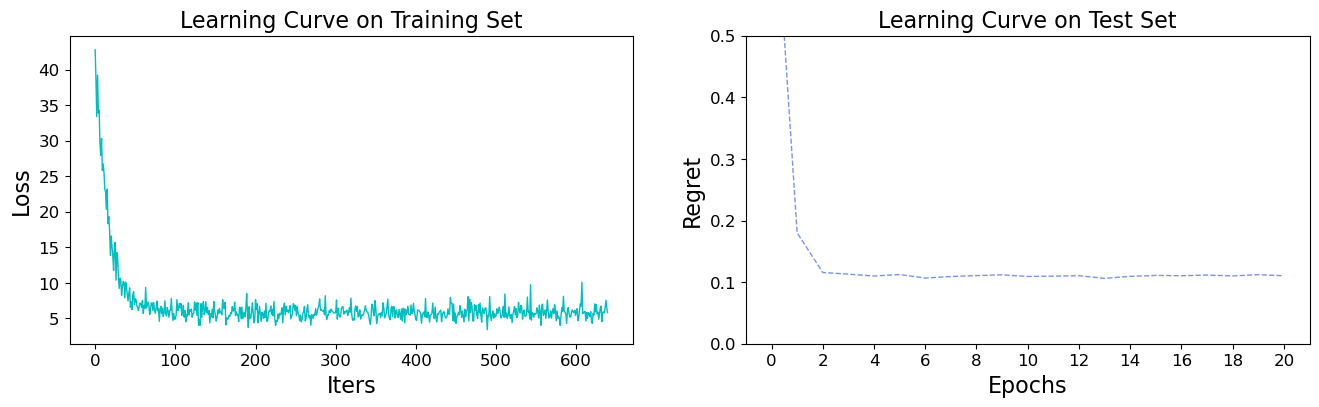

In [29]:
visLearningCurve(loss_log, loss_log_regret)

Differentiable Black-Box Solver

In [31]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.blackboxOpt`` allows us to set a differentiable solver, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``lambd``: a parameter to contral interpolation degree
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores

In [33]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def dbbl1(cp, c, z):
    # black-box optimizer
    wp = dbb(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

Num of cores: 2


Entrenamiento

In [35]:
loss_log, loss_log_regret = trainModel(reg, loss_func=dbbl1, method_name="dbb")

Epoch  1,  Loss:    4.0929,  Regret: 40.0760%
Epoch  2,  Loss:    3.9442,  Regret: 28.7150%
Epoch  3,  Loss:    3.4926,  Regret: 22.4103%
Epoch  4,  Loss:    2.5064,  Regret: 19.4357%
Epoch  5,  Loss:    2.1379,  Regret: 17.4846%
Epoch  6,  Loss:    1.4735,  Regret: 16.0949%
Epoch  7,  Loss:    1.7125,  Regret: 15.4467%
Epoch  8,  Loss:    0.9734,  Regret: 14.5745%
Epoch  9,  Loss:    1.1573,  Regret: 14.5385%
Epoch 10,  Loss:    1.3196,  Regret: 14.3165%
Epoch 11,  Loss:    1.0863,  Regret: 14.0467%
Epoch 12,  Loss:    1.3363,  Regret: 13.9997%
Epoch 13,  Loss:    1.2412,  Regret: 13.5609%
Epoch 14,  Loss:    1.1011,  Regret: 13.5201%
Epoch 15,  Loss:    0.6447,  Regret: 14.1859%
Epoch 16,  Loss:    1.1647,  Regret: 13.7452%
Epoch 17,  Loss:    1.4162,  Regret: 13.5073%
Epoch 18,  Loss:    1.3911,  Regret: 13.8889%
Epoch 19,  Loss:    0.7201,  Regret: 14.3552%
Epoch 20,  Loss:    1.0262,  Regret: 13.4645%
Total Elapsed Time: 13502.19 Sec.


Curva de aprendizaje

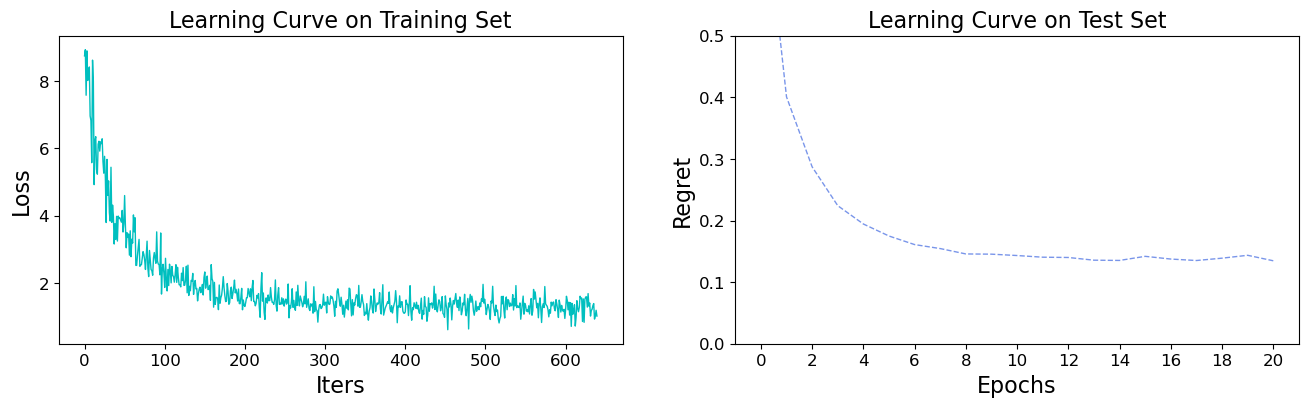

In [40]:
visLearningCurve(loss_log, loss_log_regret)

-Differentiable Perturbed Optimizer 

In [43]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedOpt`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [45]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=3, sigma=1.0, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function se tiene que definir un funcion de perdida ya que en ptb no viene incluida
def ptbl1(cp, w):
    # perturbed optimizer
    we = ptb(cp)
    # loss
    loss = l1(we, w)
    return loss

Num of cores: 2


In [46]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ptbl1, method_name="ptb")

Epoch  1,  Loss:    0.1149,  Regret: 71.1654%
Epoch  2,  Loss:    0.1113,  Regret: 69.9738%
Epoch  3,  Loss:    0.1075,  Regret: 66.3268%
Epoch  4,  Loss:    0.1119,  Regret: 63.9629%
Epoch  5,  Loss:    0.1073,  Regret: 62.3044%
Epoch  6,  Loss:    0.1177,  Regret: 61.9259%
Epoch  7,  Loss:    0.1117,  Regret: 60.5641%
Epoch  8,  Loss:    0.1056,  Regret: 58.7399%
Epoch  9,  Loss:    0.1095,  Regret: 55.5885%
Epoch 10,  Loss:    0.0984,  Regret: 53.6775%
Epoch 11,  Loss:    0.1127,  Regret: 53.0295%
Epoch 12,  Loss:    0.1042,  Regret: 51.5689%
Epoch 13,  Loss:    0.1081,  Regret: 50.8346%
Epoch 14,  Loss:    0.1111,  Regret: 49.4918%
Epoch 15,  Loss:    0.1083,  Regret: 48.7379%
Epoch 16,  Loss:    0.0998,  Regret: 48.5982%
Epoch 17,  Loss:    0.1010,  Regret: 47.4099%
Epoch 18,  Loss:    0.1036,  Regret: 46.7793%
Epoch 19,  Loss:    0.0988,  Regret: 46.2227%
Epoch 20,  Loss:    0.1077,  Regret: 46.1369%
Total Elapsed Time: 14464.59 Sec.


Curva de apredizaje

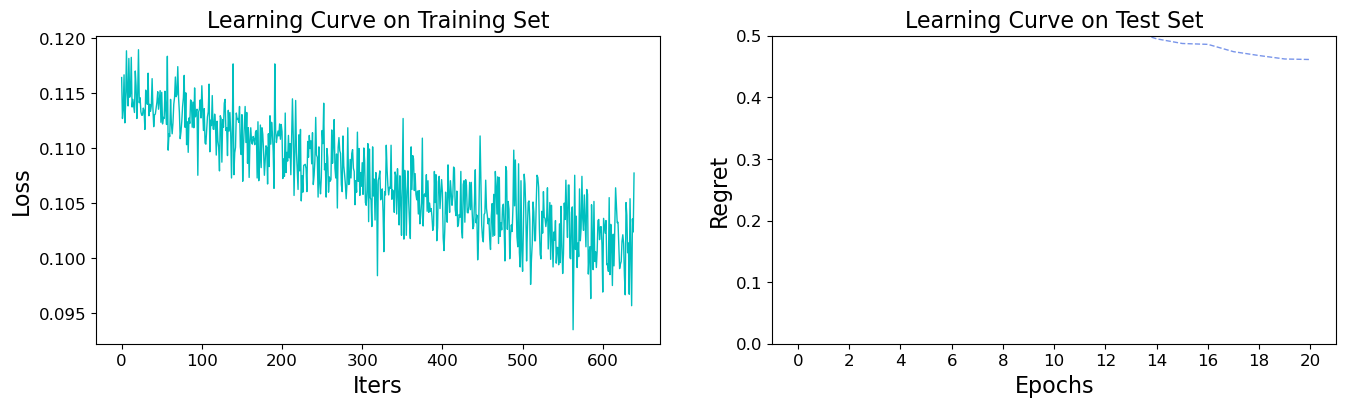

In [48]:
visLearningCurve(loss_log, loss_log_regret)

Perturbed Fenchel-Young Loss 

In [50]:
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=10, sigma=0.5, processes=2)

Num of cores: 2


In [51]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedFenchelYoung`` allows us to set a Fenchel-Young loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [53]:
# init pfyl loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0, processes=2)

Num of cores: 2


Entrenamiento

In [55]:
loss_log, loss_log_regret = trainModel(reg, loss_func=pfy, method_name="pfy")

Epoch  1,  Loss:   26.7500,  Regret: 20.8909%
Epoch  2,  Loss:   23.1389,  Regret: 13.1911%
Epoch  3,  Loss:   20.7778,  Regret: 12.0095%
Epoch  4,  Loss:   25.1944,  Regret: 11.6664%
Epoch  5,  Loss:   22.9167,  Regret: 11.2820%
Epoch  6,  Loss:   20.6667,  Regret: 11.1674%
Epoch  7,  Loss:   25.4167,  Regret: 11.1272%
Epoch  8,  Loss:   24.0000,  Regret: 10.5473%
Epoch  9,  Loss:   23.0000,  Regret: 10.8874%
Epoch 10,  Loss:   23.5278,  Regret: 10.9872%
Epoch 11,  Loss:   22.2500,  Regret: 11.0565%
Epoch 12,  Loss:   22.9444,  Regret: 10.7950%
Epoch 13,  Loss:   21.4167,  Regret: 11.0118%
Epoch 14,  Loss:   28.4722,  Regret: 10.9940%
Epoch 15,  Loss:   18.8611,  Regret: 10.9274%
Epoch 16,  Loss:   24.6389,  Regret: 10.5084%
Epoch 17,  Loss:   20.4444,  Regret: 10.8520%
Epoch 18,  Loss:   17.5000,  Regret: 10.7231%
Epoch 19,  Loss:   23.5000,  Regret: 10.5593%
Epoch 20,  Loss:   29.3333,  Regret: 10.6105%
Total Elapsed Time: 14347.97 Sec.


Curva de aprendizaje

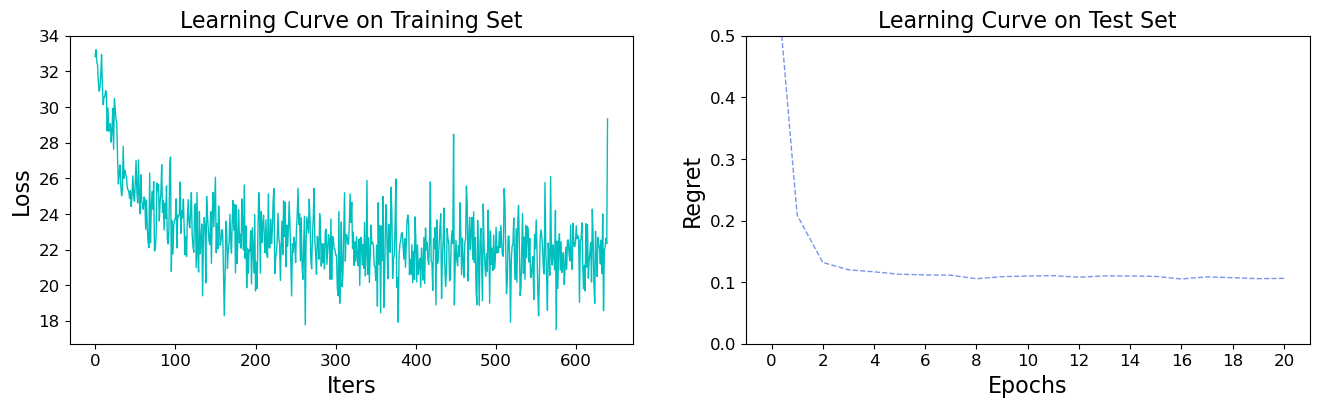

In [57]:
visLearningCurve(loss_log, loss_log_regret)